In [3]:
import os
import cv2
import copy
import time
import random
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
from torch.cuda import amp

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, GroupKFold
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.metrics import classification_report

from tqdm.notebook import tqdm
from collections import defaultdict
import albumentations as A
from albumentations.pytorch import ToTensorV2
import wandb

import timm
from pytorch_metric_learning import losses
# pip install timm
# pip install -q timm pytorch-metric-learning

In [ ]:
gpu_ids = [0, 1, 2,3]
torch.cuda.set_device(gpu_ids[0])
device = torch.device(f"cuda:{gpu_ids[0]}") if torch.cuda.is_available() else "cpu"
print(device)

In [4]:
class CFG:
    seed = 42
    model_name = 'tf_efficientnet_b4_ns'
    img_size = 512
    # model_name = 'vit_base_patch16_384'  # Vision Transformer 모델 사용
    # img_size = 384  # ViT 모델에 맞는 이미지 크기
    scheduler = 'CosineAnnealingLR'
    T_max = 10
    lr = 1e-5
    min_lr = 1e-6
    batch_size = 16
    weight_decay = 1e-6
    num_epochs = 10
    num_classes = 4
    embedding_size = 512
    num_folds = 5 # valid set 도 만들기 #############
    n_accumulate = 4
    temperature = 0.1
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

TRAIN_DIR = '/content/drive/MyDrive/Colab Notebooks/CAP/HairLoss/Training'
TEST_DIR = '/content/drive/MyDrive/Colab Notebooks/CAP/HairLoss/Validation'

df_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CAP/Train_annotations.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CAP/Test_annotations.csv')

# 라벨링 인코딩 해야할때
# le = LabelEncoder()
# df_train.label_group = le.fit_transform(df_train.label_group)

In [5]:
def set_seed(seed = 42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)


set_seed(CFG.seed)

In [6]:
from PIL import Image
import cv2

class CustomDataset(Dataset):
    def __init__(self, root_dir, df, transforms=None):
        self.root_dir = root_dir
        self.df = df
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx].PATH
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


        label = self.df.iloc[idx].LABEL

        if self.transforms:
            img = self.transforms(image=img)["image"]

        return img, label

Augmentations & Transforms

In [7]:
data_transforms = {
    "train": A.Compose([
        A.Resize(CFG.img_size, CFG.img_size),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(
                brightness_limit=(-0.1,0.1),
                contrast_limit=(-0.1, 0.1),
                p=0.5
            ),
        A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
                max_pixel_value=255.0,
                p=1.0
            ),
        ToTensorV2()], p=1.),

    "valid": A.Compose([
        A.Resize(CFG.img_size, CFG.img_size),
        A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
                max_pixel_value=255.0,
                p=1.0
            ),
        ToTensorV2()], p=1.)
}

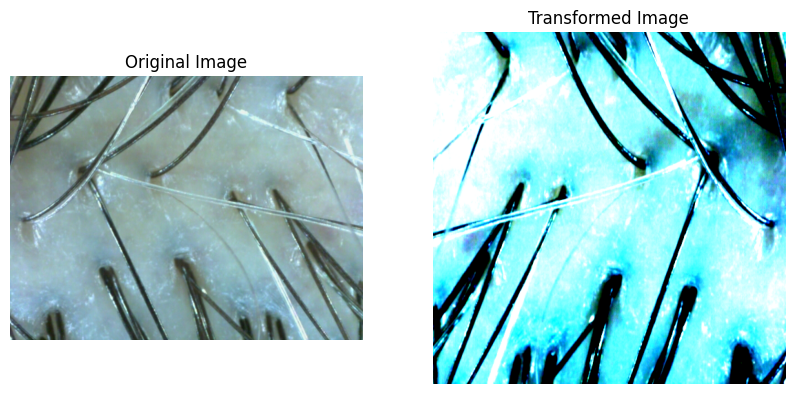

In [15]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# 예시 이미지 경로
image_path = "/content/drive/MyDrive/Colab Notebooks/CAP/HairLoss/Training/0/0177_A2LEBJJDE00152B_1604650530904_6_BH.jpg"

# 이미지 로드
image = np.array(Image.open(image_path))

# 데이터 변환 설정
transform = A.Compose([
    A.Resize(CFG.img_size, CFG.img_size),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(
        brightness_limit=(-0.1, 0.1),
        contrast_limit=(-0.1, 0.1),
        p=0.5
    ),
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
        max_pixel_value=255.0,
        p=1.0
    ),
    ToTensorV2()
])

# 원본 이미지 시각화
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')

# 변환 적용
transformed_image = transform(image=image)["image"]

# 변환된 이미지 시각화
plt.subplot(1, 2, 2)
plt.imshow(transformed_image.permute(1, 2, 0))  # 이미지의 채널 순서를 변경
plt.title("Transformed Image")
plt.axis('off')

plt.show()


In [16]:
def train_model(model, criterion, optimizer, scheduler, num_epochs, dataloaders, dataset_sizes, device):
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf
    history = defaultdict(list)
    scaler = amp.GradScaler()

    for step, epoch in enumerate(range(1,num_epochs+1)):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train','valid']:
            if(phase == 'train'):
                model.train() # Set model to training mode
            else:
                model.eval() # Set model to evaluation mode

            running_loss = 0.0

            # Iterate over data
            for inputs,labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(CFG.device)
                labels = labels.to(CFG.device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    with amp.autocast(enabled=True):
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        loss = loss / CFG.n_accumulate

                    # backward only if in training phase
                    if phase == 'train':
                        scaler.scale(loss).backward()

                    # optimize only if in training phase
                    if phase == 'train' and (step + 1) % CFG.n_accumulate == 0:
                        scaler.step(optimizer)
                        scaler.update()
                        scheduler.step()

                        # zero the parameter gradients
                        optimizer.zero_grad()


                running_loss += loss.item()*inputs.size(0)

            epoch_loss = running_loss/dataset_sizes[phase]
            history[phase + ' loss'].append(epoch_loss)

            print('{} Loss: {:.4f}'.format(
                phase, epoch_loss))

            # deep copy the model
            if phase=='valid' and epoch_loss <= best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                PATH = f"{best_loss}_epoch_{epoch}.bin"
                torch.save(model.state_dict(), PATH)

        print()

    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Loss ",best_loss)

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

In [17]:
def evaluate_model(model, criterion, data_loader, device, extract_embeddings=True):
    model.eval()
    running_loss = 0.0
    y_pred = []  # 예측된 레이블을 저장할 리스트
    y_true = []  # 실제 레이블을 저장할 리스트
    embeddings = []  # 임베딩을 저장할 리스트

    # Iterate over data
    for inputs, labels in tqdm(data_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        with torch.no_grad():
            # 모델 수정에 따라 여기를 조정해야 할 수 있음
            output = model(inputs)
            if extract_embeddings:
                # 모델이 임베딩과 클래스 예측을 모두 반환하도록 가정
                embeddings_output, class_output = output
                _, preds = torch.max(class_output, 1)
                    # outputs 텐서에서, 차원 1(보통 클래스에 대한 확률을 나타내는 차원)에 대해 최대값찾기
                    # => (각 데이터 포인트(또는 배치 내 각 샘플)에 대해 가장 높은 점수를 가진 클래스의 인덱스(예측된 클래스) 찾기 )
                embeddings.extend(embeddings_output.cpu().numpy())
            else:
                class_output = output
                _, preds = torch.max(class_output, 1)

            loss = criterion(class_output, labels)

        # Statistics
        running_loss += loss.item() * inputs.size(0)
        y_pred.extend(preds.view(-1).cpu().numpy())  # 예측값 저장 => 1차원으로 평탄화(flatten)
        y_true.extend(labels.cpu().numpy())  # 실제값 저장

    # Total loss
    total_loss = running_loss / len(data_loader.dataset)

    # classification_report를 사용한 모델 성능 평가
    print(classification_report(y_true, y_pred, target_names=[str(i) for i in range(len(np.unique(y_true)))]))

    y_true = np.concatenate(y_true, axis=0) # 모든 배치 처리를 한 뒤에 numpy 배열로 합치기

    if extract_embeddings:
      embeddings = np.concatenate(embeddings, axis=0)# 모든 배치 처리를 한 뒤에 numpy 배열로 합치기
      return total_loss, y_true, y_pred, embeddings

    else:
      return total_loss, y_true, y_pred


폴드 별로 학습시키기 => 폴드가 있을때

Load Model

In [23]:
# def initialize_model():
#   model = timm.create_model(CFG.model_name, pretrained=True)
#   in_features = model.classifier.in_features
#   model.classifier = nn.Linear(in_features, CFG.embedding_size)

#   out = model(torch.randn(1, 3, CFG.img_size, CFG.img_size))
#   #print(f'Embedding shape: {out.shape}')

#   model.to(CFG.device)
#   return model

# 모델을 수정하여 임베딩과 분류 결과를 모두 반환

class CustomModel(nn.Module):
    def __init__(self, base_model_name, pretrained=True, num_classes=None, embedding_size=CFG.embedding_size):
        super(CustomModel, self).__init__()
        self.base_model = timm.create_model(base_model_name, pretrained=pretrained, num_classes=0, global_pool='')  # num_classes=0, global_pool='' 추가
        self.num_features = self.base_model.num_features  # num_features를 직접 얻어옵니다.

        # 임베딩을 위한 레이어
        self.embedding_layer = nn.Linear(self.num_features, embedding_size)
        # 임베딩을 기반으로 한 최종 분류를 위한 레이어
        self.classifier = nn.Linear(embedding_size, num_classes)

    def forward(self, x):
        x = self.base_model(x)
        # timm 모델이 자동으로 피처 맵을 평균 풀링하여 반환하므로 추가 변환 필요 없음
        embedding = self.embedding_layer(x)
        out = self.classifier(embedding)
        return embedding, out


# 커스텀 임베딩 레이어와 분류 레이어를 추가
def initialize_model():
    num_classes = 4 #len(np.unique(y_true))  # `y_true`는 레이블의 numpy 배열입니다. 실제 클래스 수에 맞게 설정해주세요.
    model = CustomModel(CFG.model_name, pretrained=True, num_classes=num_classes)
    model = nn.DataParallel(model, device_ids=gpu_ids)
    model.to(CFG.device)
    return model

# 모델정의해주기
model = initialize_model()

LOSS

In [24]:
class SupervisedContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.1):
        super(SupervisedContrastiveLoss, self).__init__()
        self.temperature = temperature

    def forward(self, feature_vectors, labels):
        # Normalize feature vectors
        feature_vectors_normalized = F.normalize(feature_vectors, p=2, dim=1)
        # Compute logits
        logits = torch.div(
            torch.matmul(
                feature_vectors_normalized, torch.transpose(feature_vectors_normalized, 0, 1)
            ),
            self.temperature,
        )
        return losses.NTXentLoss(temperature=0.07)(logits, torch.squeeze(labels))

In [25]:
criterion = SupervisedContrastiveLoss(temperature=CFG.temperature).to(CFG.device) # Custom Implementation
optimizer = optim.Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr)

In [26]:
fold_losses = []

def main(model, criterion, optimizer, scheduler, device, num_epochs):

    skf = StratifiedKFold(n_splits=CFG.num_folds, shuffle=True, random_state=42)

    test_df = df_test
    train_df = df_train
    # Test data custom
    test_data = CustomDataset(TEST_DIR, test_df, transforms=None)
    test_loader = DataLoader(test_data, batch_size=CFG.batch_size, shuffle=False)

    # Train, valid custom. # train, test split은 매개변수가 중요함
    for fold, (train_index, valid_index) in enumerate(skf.split(train_df, train_df['LABEL'])):
        print(f'Fold {fold + 1}')

        train_sampler = SubsetRandomSampler(train_index)
        valid_sampler = SubsetRandomSampler(valid_index)

        train_data = CustomDataset(TRAIN_DIR, train_df, transforms=data_transforms["train"])
        valid_data = CustomDataset(TRAIN_DIR, train_df, transforms=data_transforms["valid"])

        # 데이터로더 초기화
        train_loader = DataLoader(train_data, batch_size=CFG.batch_size, sampler=train_sampler)
        valid_loader = DataLoader(train_data, batch_size=CFG.batch_size, sampler=valid_sampler)

        dataset_sizes = {
        'train' : len(train_data),
        'valid' : len(valid_data)
         }

        dataloaders = {
        'train' : train_loader,
        'valid' : valid_loader
         }

        # 모델 초기화
        model = initialize_model()
        

        wandb.init(
        entity="nanhungrybin",
        project="HairLoss_0402"
        )
        config = wandb.config

        if config.criterion == "CrossEntropyLoss":
            criterion = nn.CrossEntropyLoss()
        elif config.criterion == "SupervisedContrastiveLoss":
            criterion = SupervisedContrastiveLoss()


        # Train
        model, history = train_model(model, config.criterion, optimizer, scheduler, num_epochs, dataloaders, dataset_sizes, device)
        # Evaluate on test set
        print(f"{fold} 폴드 성능평가")
        test_loss, y_true, y_pred, embeddings = evaluate_model(model, config.criterion, test_loader, device, extract_embeddings=True)
        print("Test Loss: {:.4f}".format(test_loss))
        fold_losses.append(test_loss)

    mean_losses = np.mean(fold_losses)

    return model, history, mean_losses, embeddings, y_true

In [ ]:
sweep_config = {
        "name": "hyperparameter_tuning",
        "method": "grid",
        "metric": {"goal": "maximize", "name": "accuracy"},

        "parameters": {
            "loss_function":{'values': ["CrossEntropyLoss","SupervisedContrastiveLoss"]}
        }
    }

sweep_id = wandb.sweep(sweep_config)

############ Sweep 작업 실행 ########################
wandb.agent(sweep_id, main, count=2)

In [27]:
model, history, mean_losses, embeddings, y_true = main(model, criterion, optimizer, scheduler, device=CFG.device, num_epochs=CFG.num_epochs)

Fold 1


/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name tf_efficientnet_b4_ns to current tf_efficientnet_b4.ns_jft_in1k.
  model = create_fn(


Epoch 1/10
----------


  0%|          | 0/926 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 42.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 21.06 MiB is free. Process 1864 has 14.72 GiB memory in use. Of the allocated memory 14.46 GiB is allocated by PyTorch, and 141.85 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
plt.style.use('fivethirtyeight')
plt.rcParams["font.size"] = "20"
fig = plt.figure(figsize=(22,8))
epochs = list(range(CFG.num_epochs))
plt.plot(epochs, history['train loss'], label='train loss')
plt.plot(epochs, history['valid loss'], label='valid loss')
plt.ylabel('Loss', fontsize=20)
plt.xlabel('Epoch', fontsize=20)
plt.legend()
plt.title('Loss Curve');

임베딩 시각화

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def visualize_embeddings(embeddings, labels):
    tsne = TSNE(n_components=2, random_state=123)
    reduced_embeddings = tsne.fit_transform(embeddings)

    plt.figure(figsize=(10, 10))
    for i in range(len(np.unique(labels))):
        plt.scatter(reduced_embeddings[labels == i, 0], reduced_embeddings[labels == i, 1], label=i)
    plt.legend()
    plt.show()


# 임베딩 시각화
visualize_embeddings(embeddings, y_true)

1. VIT-contrast
2. Resnet-contrast
3. Efficient-contrast

1. VIT-cross
2. Resnet-cross
3. Efficient-cross

contrast => 더 찾아보기